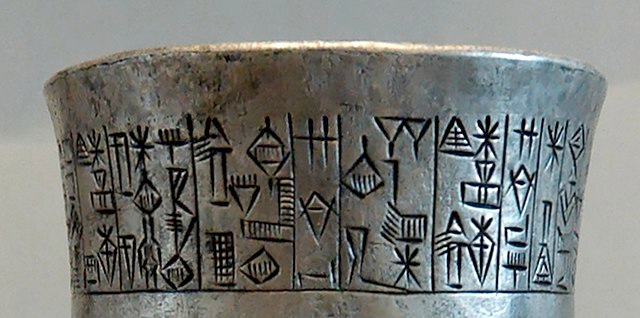

# Detect language of Cuneiform text

In this notebook, I will detect whether the cueniform text is Sumerian or not. As explained in the dataset description, the language can either be Sumerian or a dialect of Akkadian. We will treat all Akkadian dialects as the same language, and therefore train a binary classifier.

# The QLattice

The QLattice is a supervised machine learning tool for symbolic regression developed by [Abzu](https://www.abzu.ai) . It is inspired by Richard Feynman's path integral formulation. That's why the python module to use it is called *Feyn*, and the *Q* in QLattice is for Quantum.

QLattices have been shown in research to perform very well and yield simple and explainable models: [Symbolic regression outperforms other models for small data sets](https://arxiv.org/abs/2103.15147)

Abzu provides free QLattices for non-commercial use to anyone. These free community QLattices gets allocated for us automatically if we use Feyn without an active subscription, as we will do in this notebook. Read more about how it works here: https://docs.abzu.ai/docs/guides/getting_started/community.html

The feyn Python module is not installed on Kaggle by default so we have to pip install it first. 

__Note__: the pip install will fail unless you enable *Internet* in the *settings* to the right --->

In [ ]:
!pip install feyn

# Python imports
In this notebook we will use only two python modules: the `feyn` module to access the QLattice, and the `pandas` module to access the data

In [ ]:
import pandas as pd
import feyn

# Data
Read in the data and have a quick look at it:

In [ ]:
df = pd.read_csv("/kaggle/input/cuneiform-language-identification/train.csv")
df.sample(10).head()

# Create binary target
Convert the class label to a binary target. Sumerian or not

In [ ]:
df["lang"]=(df["lang"]=="SUX").astype(int)

# Extract the first 5 symbols
We will base the classifier on the first 5 symbols in each text

In [ ]:
for i in range(0, 5):
    df[f"c{i}"] = df["cuneiform"].str[i]

In [ ]:
df = df.drop(["cuneiform"],axis=1)

In [ ]:
df.head()

# Split the dataset in train/test

FOr now we'll only yuse 10% for training. This leaves a lot of room for validation.

In [ ]:
train,validation = feyn.tools.split(df,ratio=(1,9), random_state=42)

# Allocate a QLattice
The actual QLattice is a quantum simulator that runs on Abzu's hardware, but we can allocate one to use for our analysis with a single line of code. Hopefully the following line will get us one.

In [ ]:
ql = feyn.connect_qlattice()

# Resetting and reproducability
The QLattice has the potential to store learnings between sessions to enable transfer of learning and federated learning. This is not possible with Community QLattices, since a new one gets allocated whenever we run the notebook, so it is not strictly necessary to call the reset function on our new QLattice. 

But the reset function also allows us to provide a random seed, which will ensure that we get the same results every time we run this notebook

In [ ]:
ql.reset(random_seed=42)

# Data types
All of the symbols are categorical variables. The QLattice will work fine with these. We just need to tell it about it. We will create a `dict` named `stypes` with this information which we will pass to the QLattice later. Read more about categorical data in the QLattice here: https://docs.abzu.ai/docs/guides/essentials/stypes.html


In [ ]:
stypes={
    "c0": "cat",
    "c1": "cat",
    "c2": "cat",
    "c3": "cat",
    "c4": "cat",
}

# Search for the best model
We are now ready to instruct the QLattice to search for the best mathematical model to explain the data. Here we use the high-level convenience function that does everything with sensible defaults: https://docs.abzu.ai/docs/guides/essentials/auto_run.html. 

For more detailed control, we could use the primitives: https://docs.abzu.ai/docs/guides/primitives/using_primitives.html

Notice that the `stypes` dictionary we created earlier gets passed to the QLattice here. 

__NOTE:__ This will take several minutes to complete. It invoves work done on the QLattice machine remotely as well as in the local notebook. The part that runs locally is slowing things down because of the limited CPU resources on Kaggle. Running the same on my machine locally only takes 20 seconds!

In [ ]:
models = ql.auto_run(train, output_name="lang", kind="classification", criterion="aic", n_epochs=20, stypes=stypes)

# Evaluate
The QLattice has found a mathematical relationship tha can relate the coneiform symbols to the language. The final step is to evaluate the model on the test and the train set. To do that we plot the *ROC* curve of the classifier on both the test and the training data. You can read more about ROC curves here: https://docs.abzu.ai/docs/guides/plotting/roc_curve.html

In this case they overlap almost perfectly which indicates that the model generalizes to unseen data very well.

In [ ]:
models[0].plot_roc_curve(train, label="Training data")
models[0].plot_roc_curve(validation, label="Validation data")

# Confusion matrix
A simpler and less powerfull way to evaluate classifiers is a confusion matrix: https://docs.abzu.ai/docs/guides/plotting/confusion_matrix.html

Let us see how that looks at various thresholds:

In [ ]:
models[0].plot_confusion_matrix(validation, threshold=.3)

In [ ]:
models[0].plot_confusion_matrix(validation, threshold=.5)

In [ ]:
models[0].plot_confusion_matrix(validation, threshold=.8)

# Conclusion
In a few lines of code we were able to create a classifier that was quite accurate as measured by AUC. I plan to do several improvements in later versions:
- Train on more of the data
- Use sample_weights to balance the training
- Plot the importance of the individual signs in the text